# Goal

In this notebook, we aim to build a baseline for 
comparing with shortest path learning.

This baseline combines both greedy strategy and 
randomization. Stated differently, a greedy agent
is exploiting the greedy stragy and explore by
a certain probability $p$.

The agent has probability $1-p$ to choose the
edge with smallest weight and has $p$ to randomly
select remaining edges.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import logging
from utils import plot_g

In [2]:
WEIGHT_MIN = .5
WEIGHT_MAX = 1.

def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.node[tmp_node]['x'], G.node[tmp_node]['y']])
    p_2 = np.array([G.node[node]['x'], G.node[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(num_nodes=100,\
                          min_out_degree=2,\
                          max_out_degree=4,\
                          weight_min=WEIGHT_MIN,\
                          weight_max=WEIGHT_MAX,\
                          grid_size=20000):
    
    G = nx.Graph()
    
    euclidean_coords = np.linspace(0.0, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:num_nodes]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes():
        
        tmp_nodes = list(G.nodes())
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            geo_dist = calc_euclidean_dist(G, tmp_node[0], node)
            
            G.add_edge(node, tmp_node[0], weight=weight * geo_dist)
            
    return G

4
2
100
167


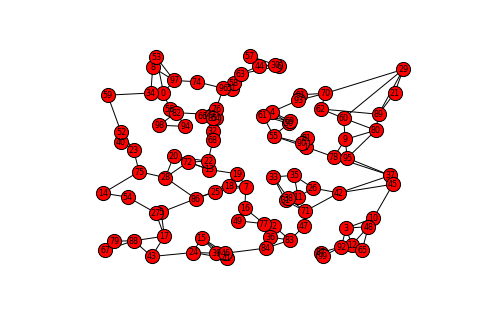

In [3]:
G = generate_low_degree_g()
max_degree_node = max(G.degree(), key=lambda k: G.degree()[k])
min_degree_node = min(G.degree(), key=lambda k: G.degree()[k])
print(G.degree()[max_degree_node])
print(G.degree()[min_degree_node])
print(G.number_of_nodes())
print(G.number_of_edges())

plot_g(G, with_labels=True, node_size=200, font_size=8)

In [4]:
# when p is 0, this is a pure greedy strategy

def shortest_path_baseline(G, src, dst, p=0.0, invalid_path_threshold=G.number_of_nodes()):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        node_weights = list(map(lambda t: (t[1],\
                        G.get_edge_data(cur_node, t[1])['weight']),\
                        G.edges(cur_node)))
        
        num_neighbors = len(G.neighbors(cur_node))
        assert num_neighbors == len(node_weights)
        
        node_weight_min = min(node_weights, key=lambda d:d[1])
        
        min_idx = node_weights.index(node_weight_min)
        sample_probabilities = [p/(num_neighbors-1) for _ in range(num_neighbors)]
        sample_probabilities[min_idx] = 1-p
        
        assert sum(sample_probabilities) <= 1.0
        next_node = np.random.choice(G.neighbors(cur_node), 1, p=sample_probabilities)[0]
        weight = G.edge[cur_node][next_node]['weight']
        
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [160]:
def sample_node_pairs(num_node_pairs, num_of_nodes):
    
    pair_path_dict = dict()
    
    while True:
        
        if len(pair_path_dict) >= num_node_pairs:
            break
        
        src = np.random.randint(0, num_of_nodes)
        dst = np.random.randint(0, num_of_nodes)
        
        if src == dst or (src, dst) in pair_path_dict or not nx.has_path(G, src, dst):
            continue
            
        pair_path_dict[(src, dst)] = []
        pair_path_dict[(dst, src)] = []
        
    return pair_path_dict

In [248]:
G = generate_low_degree_g()
pair_path_dict = sample_node_pairs(200, G.number_of_nodes())

In [249]:
p_group = [0.75, 0.5, 0.25, 0.0]

arrival_rate = [[] for _ in range(len(p_group))]
edge_efficiency_groups = [[] for _ in range(len(p_group))]
time_efficiency_groups = [[] for _ in range(len(p_group))]

for idx_p_group, p in enumerate(p_group):
    
    print("Working on %f group" % p)
    
    for i in range(100):
        
        if i > 0 and i % 20 == 0:
            print("Repeated %d times" % i)
            
        cnt = 0
        edge_efficiency = []
        time_efficiency = []
        
        for pair in pair_path_dict:
            src, dst = pair[0], pair[1]
            path, weights, found = shortest_path_baseline(G, src, dst, p=p)

            if not found:
                continue
                
            cnt += 1
            
            dijkstra_path = nx.dijkstra_path(G, src, dst)
            
            edge_efficiency.append(float(len(dijkstra_path)-1) / (len(path)-1))
            time_efficiency.append(calc_path_weight_sum(G, dijkstra_path) \
                                        / calc_path_weight_sum(G, path))

        arrival_rate[idx_p_group].append(float(cnt)/len(pair_path_dict))
        
        edge_efficiency_groups[idx_p_group].append(edge_efficiency)
        
        time_efficiency_groups[idx_p_group].append(time_efficiency)
        

Working on 0.750000 group
Repeated 20 times
Repeated 40 times
Repeated 60 times
Repeated 80 times
Working on 0.500000 group
Repeated 20 times
Repeated 40 times
Repeated 60 times
Repeated 80 times
Working on 0.250000 group
Repeated 20 times
Repeated 40 times
Repeated 60 times
Repeated 80 times
Working on 0.000000 group
Repeated 20 times
Repeated 40 times
Repeated 60 times
Repeated 80 times


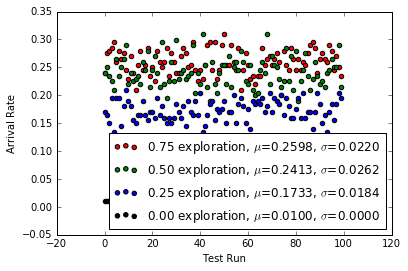

In [258]:
colors = ['r', 'g', 'b', 'k']

for idx, rate in enumerate(arrival_rate):
    stat_mean = np.mean(rate)
    stat_std = np.std(rate)
    label = u'%0.2f exploration, $\mu$=%0.4f, $\sigma$=%0.4f' % \
            (p_group[idx], stat_mean, stat_std)
    
    plt.scatter(list(range(100)), rate, label=label, c=colors[idx])

plt.ylabel("Arrival Rate")
plt.xlabel("Test Run")
plt.legend(loc='lower right')
plt.show()

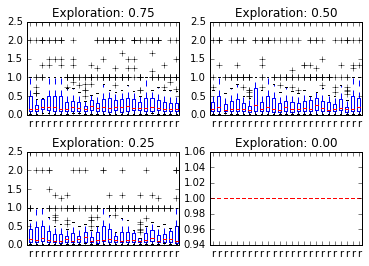

In [332]:
del f, axarr
f, axarr = plt.subplots(2, 2)

for i in range(4):
    random.shuffle(edge_efficiency_groups[i])
    axarr[int(i/2), i%2].boxplot(edge_efficiency_groups[i][:25], labels=['r'] * 25)
    axarr[int(i/2), i%2].set_title("Exploration: %0.2f"% p_group[i])

f.subplots_adjust(hspace=0.4)
plt.show()
